In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import os
import sys
from pathlib import Path
from tqdm import tqdm

from scipy.stats import boxcox

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

ERA_DATA_PATH = str(HOME / 'system_tests/data/ERA5')

from dsrnngan.data import load_imerg_raw, load_hdf5_file, filter_by_lat_lon
from dsrnngan.plots import plot_precipitation

2022-11-14 15:07:11.117168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 15:07:11.676099: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 15:07:19.927861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /system/slurm/22.05.2/lib:/system/pmix-v3/lib:/user/work/uz22147/miniconda3/lib:/user/work/uz22147/miniconda3/lib/:/user/work/uz22147/miniconda3/lib/
2022-11-14 15:07:19.928187: W tensorflow/stream_execut

In [9]:
import random
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm

from dsrnngan.data import order_coordinates
from matplotlib import colorbar, colors, gridspec

year = 2018
# month = random.choice(np.arange(1, 12, 1))
month = 3 # Use one of the rainier months
# day = 4
# hour = 20
hours =range(0, 24, 1)

# fig, ax = plt.subplots(len(hours), 1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(40, 40))

rainfall_percentages = []
null_values_dict = {}

n = 0
for day in tqdm(range(1, 5)):
    for hour in hours:
        for half_hour in [0, 1]:
            
            if half_hour == 0:
                suffix = f'-S{hour:02d}0000-E{hour:02d}2959.*'
            else:
                suffix = f'-S{hour:02d}3000-E{hour:02d}5959.*'
            imerg_fps = glob.glob(f'/bp1/geog-tropical/data/Obs/IMERG/half_hourly/final/3B-HHR.MS.MRG.3IMERG.{year}{month:02d}{day:02d}{suffix}')

            latitude_vals=np.arange(-12, 13, 0.1)
            longitude_vals=np.arange(25, 50, 0.1)
            # latitude_vals=np.arange(0 + 1e-5, 2 + 1e-5, 0.1)
            # longitude_vals=np.arange(29+ 1e-5, 31+ 1e-5, 0.1)
            # latitude_vals=np.arange(0 , 2, 0.1)
            # longitude_vals=np.arange(29, 31, 0.1)

            ds_raw = load_hdf5_file(imerg_fps[0])
            ds_raw = order_coordinates(ds_raw)

            ds = filter_by_lat_lon(ds_raw, lat_range=latitude_vals, lon_range=longitude_vals)
            
            # fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
            im, ax = plot_precipitation(ds, 'precipitationCal', log_precip=True, ax=ax, fig=fig, tick_interval=1)
            # ax.pcolormesh(ds['precipitationCal'][0, :, :], vmin=0, vmax=5)
 
            if half_hour == 0:
                title_time = f'{hour:02d}:00:00'
            else:
                title_time = f'{hour:02d}:30:00'
            plt.title(f'iMERG: {year}-{month:02d}-{day:02d} {title_time}')
            cbar = plt.colorbar(im, ax=ax)

            cbar.ax.set_ylabel('precipitation estimate (mm/hr)')
            plt.savefig(f'figs/test_{n}.jpg')
            plt.show()
            raise ValueError
            
            n +=1
            
            null_values_dict[hour] = np.isnan(ds['precipitationCal'].values).sum() /  len( ds['precipitationCal'].values.flatten())
            
            precip = ds_raw['precipitationCal'].isel(time=0).values
            # print((precip > 0.1).mean())
            rainfall_percentages.append((precip > 0.1).mean())
            
            # era5_ds = load_era5_day_raw('tp', year, month, day, latitude_vals=latitude_vals, longitude_vals=longitude_vals,
            #                     interpolate=True)
            # era5_ds = order_coordinates(era5_ds)
            # era5_ds['tp'] = 1000 * era5_ds['tp'] / 24 # roughly mm/hr
            # plot_precipitation(era5_ds, 'tp', log_precip=True, ax=ax[1], fig=fig,
            #                 lat_var_name='latitude', lon_var_name='longitude')


  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#  Create video
import cv2
import numpy as np
import glob

img_array = []
for m in range(n):
    filename = f'figs/test_{m}.jpg'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('imerg_precip.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


In [ ]:
# Get an idea of distribution of rainfall
from calendar import monthrange

all_dates = []
for year in [2018]:
    for month in np.arange(1, 13):
        for day in range(1, monthrange(year, month)[1]+1):
            all_dates.append((year, month, day))

In [ ]:
from dsrnngan.data import RADAR_PATH
from datetime import datetime

year = 2018
month = 12
day = 31
hour = 12
dt_start = datetime(year, month, day, hour, 0, 0)

hourly_glob_str = os.path.join(RADAR_PATH, '3B-HHR.MS.MRG.3IMERG.' + dt_start.strftime('%Y%m%d-S%H*'))
fps = glob(hourly_glob_str)
print(hourly_glob_str)


[autoreload of dsrnngan.data failed: Traceback (most recent call last):
  File "/user/work/uz22147/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/user/work/uz22147/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/user/work/uz22147/miniconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/user/home/uz22147/repos/downscaling-cgan/dsrnngan/data.py", line 501, in <module>
    def get_era5_filepath_prefix(variable, era_data_dir=RAW_FCST_PATH,
NameError: name 'RAW_FCST_PATH' is not defined
]


TypeError: 'module' object is not callable

In [ ]:
latitude_vals=np.arange(-12, 13, 0.1)
longitude_vals=np.arange(25, 50, 0.1)

# Get an idea of distribution of rainfall
from calendar import monthrange

all_dates = []
for year in [2018]:
    for month in np.arange(1, 13):
        for day in [1, 4, 8, 12, 16, 20]:
            for hour in [6, 12, 18]:
                all_dates.append((year, month, day, hour))

datasets = []
for (year, month, day, hour) in tqdm(all_dates, total=len(all_dates)):
    tmp_ds = load_imerg_raw(year, month, day, hour,
                        latitude_vals=latitude_vals, longitude_vals=longitude_vals)
    datasets.append(tmp_ds)
ds = xr.concat(datasets, dim='time')

100%|██████████| 216/216 [08:55<00:00,  2.48s/it]


(array([2.4766565e+07, 3.8401000e+05, 2.7391600e+05, 2.1651700e+05,
        1.8217800e+05, 1.5271600e+05, 1.3083300e+05, 1.1425900e+05,
        1.0068400e+05, 8.8350000e+04, 7.6914000e+04, 6.7857000e+04,
        6.0459000e+04, 5.3075000e+04, 4.7660000e+04, 4.1965000e+04,
        3.5881000e+04, 3.1538000e+04, 2.7647000e+04, 2.4572000e+04,
        2.0687000e+04, 1.7656000e+04, 1.4730000e+04, 1.2433000e+04,
        1.0698000e+04, 8.5620000e+03, 7.2900000e+03, 6.1580000e+03,
        5.0360000e+03, 4.1360000e+03, 3.3080000e+03, 2.5340000e+03,
        2.0160000e+03, 1.6060000e+03, 1.3080000e+03, 1.0550000e+03,
        7.5200000e+02, 6.7300000e+02, 4.6200000e+02, 3.0000000e+02,
        2.7400000e+02, 1.8800000e+02, 1.4600000e+02, 1.5900000e+02,
        8.1000000e+01, 8.5000000e+01, 3.7000000e+01, 2.3000000e+01,
        9.0000000e+00, 2.0000000e+00]),
 array([0.        , 0.03876028, 0.07752056, 0.11628083, 0.15504111,
        0.19380139, 0.23256166, 0.27132195, 0.31008223, 0.3488425 ,
        

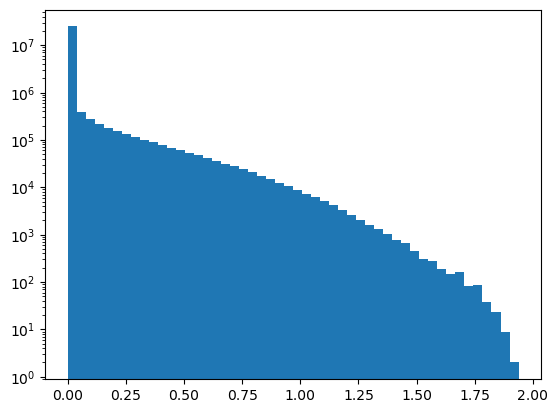

In [ ]:
import matplotlib.pyplot as plt

precip_vals = np.log10(1 + ds['precipitationCal'].values.flatten())

plt.hist(precip_vals, bins=50, log=True)

In [11]:
# F mean monthly totals
# Get an idea of distribution of rainfall
import os, sys
import numpy as np
import pickle

from pathlib import Path
from tqdm import tqdm

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.data import load_imerg_raw, load_era5_month_raw
from calendar import monthrange

hours = range(24)

latitude_vals = np.arange(-12, 16, 0.25)
longitude_vals = np.arange(22, 49, 0.25)

total_rainfall_dict = {}
monthly_rainfall_dict = {}
monthly_rainfall_dict_era5 = {}

for year in [2016]:

    total_rainfall_dict[year] = {}
    monthly_rainfall_dict[year] = {}
    monthly_rainfall_dict_era5[year] = {}

    print('Year=', year)
    
    for month in [6, 7]:
        
        total_rainfall_dict[year][month] = {}
        monthly_rainfall = 0
        
        for day in range(1, monthrange(year, month)[1]+1):
            daily_rainfall = 0
            hourly_rainfall = []
            for hour in np.arange(0, 24, 4):
                # This sselects with method = 'nearest' so grid resolution should match era5
                ds_hr = load_imerg_raw(year, month, day, hour, 
                                       imerg_data_dir='/bp1/geog-tropical/users/uz22147/east_africa_data/IMERG/half_hourly/final')
                ds_hr = ds_hr.sel(lat=latitude_vals, method='backfill').sel(lon=longitude_vals, method='backfill')

                # average over half hours
                precip_hourly_values = ds_hr['precipitationCal']
                hourly_rainfall.append(precip_hourly_values)
                
                daily_rainfall += precip_hourly_values
                tmp_lat_vals = ds_hr.lat.values
                tmp_lon_vals = ds_hr.lon.values
                ds_hr.close()
                            
            total_rainfall_dict[year][month][day] = daily_rainfall
            monthly_rainfall += daily_rainfall
        monthly_rainfall_dict[year][month] = monthly_rainfall
        
        # era5
        era5_ds = load_era5_month_raw('tp', year=year, month=month, era_data_dir='/bp1/geog-tropical/users/uz22147/east_africa_data/ERA5')
        era5_ds = era5_ds.sel(latitude=latitude_vals, method='backfill').sel(longitude=longitude_vals, method='backfill')
        
        era5_ds_monthly = era5_ds.sum('time')                             
        assert len(era5_ds.latitude.values) == len(tmp_lat_vals)
        assert len(era5_ds.longitude.values) == len(tmp_lon_vals)
        
        monthly_rainfall_dict_era5[year][month] = era5_ds_monthly['tp'].values
        era5_ds.close()
        era5_ds_monthly.close()

        with open('total_rainfall.pkl', 'wb+') as ofh:
            pickle.dump(total_rainfall_dict, ofh)

        with open('monthly_rainfall.pkl', 'wb+') as ofh:
            pickle.dump(monthly_rainfall_dict, ofh)
            
        with open('monthly_rainfall_era5.pkl', 'wb+') as ofh:
            pickle.dump(monthly_rainfall_dict_era5, ofh)
    

Year= 2016


In [12]:
monthly_rainfall_dict[2016][6].values.shape

(112, 108)

In [25]:
import pickle

with open('../total_rainfall.pkl', 'rb') as ifh:
    total_rainfall_dict = pickle.load(ifh)


with open('../monthly_rainfall.pkl', 'rb') as ifh:
    monthly_rainfall_dict = pickle.load(ifh)
    
with open('../monthly_rainfall_era5.pkl', 'rb') as ifh:
    monthly_rainfall_era5_dict = pickle.load(ifh)

In [27]:
# Get average monthly rainfall from yearly data
import numpy as np
from calendar import monthrange
monthly_total = {m: np.zeros([112, 112]) for m in np.arange(1,13)}
monthly_total_era5 = {m: np.zeros([112, 112]) for m in np.arange(1,13)}

for year, month_vals in monthly_rainfall_dict.items():
    for month, month_data in month_vals.items():
        monthly_total[month] += month_data.values
        
for year, month_vals in monthly_rainfall_era5_dict.items():
    for month, month_data in month_vals.items():
        monthly_total_era5[month] += month_data

all_years = list(monthly_rainfall_dict.keys())
num_years = len(monthly_rainfall_dict.keys())

# Take averages
avg_monthly_rainfall = {k: v/num_years for k, v in monthly_total.items()}

all_era5_years = list(monthly_rainfall_era5_dict.keys())
num_era5_years = len(monthly_rainfall_era5_dict.keys())

# Take averages
avg_monthly_rainfall_era5 = {k: v/num_era5_years for k, v in monthly_total_era5.items()}

# get alternative view from adding up daily values
monthly_totals = {}
for year in all_years:
    monthly_totals[year] = {}
    for month in np.arange(1, 13):
        monthly_totals[year][month] = np.zeros((112, 112))
        for day in range(1, monthrange(year, month)[1]+1):
            monthly_totals[year][month] += total_rainfall_dict[year][month][day].values


In [28]:
import os
import pickle
from pathlib import Path
import cartopy.feature as cfeature

import cartopy.crs as ccrs
import numpy as np
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_img_log_coastlines
from dsrnngan import data

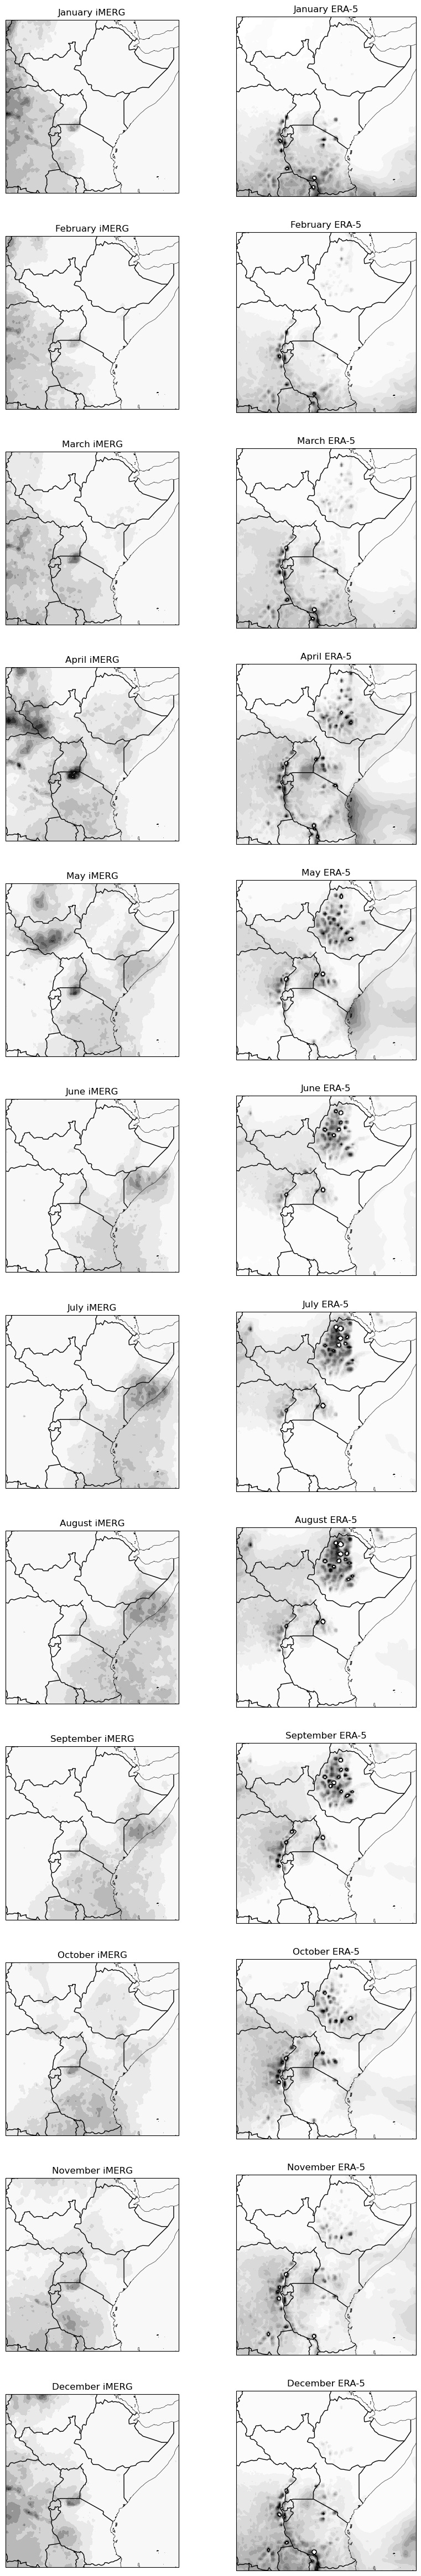

In [31]:
from datetime import date

palette="YlGnBu"
linewidth = 0.4
cmap = ListedColormap(sns.color_palette(palette, 256))
cmap.set_under('white')
latitude_vals = np.arange(-12, 16, 0.25)
longitude_vals = np.arange(22, 50, 0.25)
extent = [min(data.DEFAULT_LONGITUDE_RANGE), max(data.DEFAULT_LONGITUDE_RANGE), min(data.DEFAULT_LATITUDE_RANGE), max(data.DEFAULT_LATITUDE_RANGE)]

alpha = 0.8
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
cb_tick_loc = np.array([0.1, 0.5, 1, 2, 5, 15, 30, 50])
cb_tick_labels = [0.1, 0.5, 1, 2, 5, 15, 30, 50]
value_range_precip=(0.1, 30)
num_cols = 2
num_rows = 12
figsize = (num_cols*5, num_rows*5)
# plt.figure(figsize=figsize)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize, 
                        subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'width_ratios': [1, 1.25]})
for month in np.arange(1, 13):
    
    row = month -1
    # row = (month-1) // 3
    # col = month-1 - (row) * num_cols

    max_val = avg_monthly_rainfall[month].max()
    axs[row, 0].coastlines(resolution='10m', color='black', linewidth=linewidth)
    
    im = axs[row, 0].contourf(longitude_vals, latitude_vals , avg_monthly_rainfall[month][ :,:], transform=ccrs.PlateCarree(),
                        cmap='Greys', levels=np.linspace(0, 650, 10))
    
    axs[row, 0].set_title(date(2020, month, 1).strftime('%B') + ' iMERG')
    
    axs[row, 1].coastlines(resolution='10m', color='black', linewidth=linewidth)
    im = axs[row, 1].contourf(longitude_vals, latitude_vals , avg_monthly_rainfall_era5[month][ :,:], transform=ccrs.PlateCarree(),
                        cmap='Greys', levels=np.linspace(0, 650, 15))
    axs[row, 1].set_title(date(2020, month, 1).strftime('%B') + ' ERA-5')
    # plot_img_log_coastlines(avg_monthly_rainfall[month][ :,:], value_range_precip=value_range_precip,
    #                                     cmap=cmap,
    #                                     extent=extent,
    #                                     alpha=alpha)
    # plt.colorbar(im)

    axs[row, 0].add_feature(cfeature.BORDERS)
    axs[row, 1].add_feature(cfeature.BORDERS)
plt.savefig('Month_averages.png')
# ax.add_feature(cfeature.LAKES)


In [76]:
### Timing the load imerg function

from dsrnngan.data import load_imerg

In [77]:
ds = load_imerg('20181230', 18, data_dir='/home/uz22147/repos/downscaling-cgan/system_tests/data/IMERG/half_hourly/final')

In [7]:
# plot the total monthly rainfall

import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
y_era5 = []

years = [2016, 2017, 2018, 2019]

monthly_totals = {m: 0 for m in range(1, 13)}
monthly_totals_era5 = {m: 0 for m in range(1, 13)}

for year in years:
    for month in range(1, 13):
           ym = f'{year}-{month:02d}'
           x.append(ym)
           
           imerg_val = monthly_rainfall_dict[year][month]
           y.append(imerg_val)
           monthly_totals[month] +=  imerg_val
           
           era5_val = monthly_rainfall_era5_dict[year][month]
           y_era5.append(era5_val)
           monthly_totals_era5[month] += era5_val
monthly_average = {k: v/len(years) for k, v in monthly_totals.items()}
monthly_average_era5 = {k: v/len(years) for k, v in monthly_totals_era5.items()}

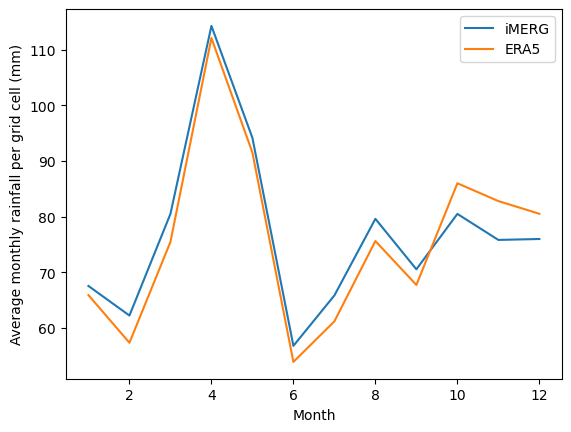

In [26]:
fig, ax = plt.subplots()

ax.plot(range(1,13), np.array(list(monthly_average.values())) / 113**2, label='iMERG')
ax.plot(range(1,13), np.array(list(monthly_average_era5.values())) / 113**2, label='ERA5')
ax.set_ylabel('Average monthly rainfall per grid cell (mm)')
ax.set_xlabel('Month')
# ax.tick_params(axis='x', rotation=90)
ax.legend()

In [5]:
monthly_rainfall_era5_dict[2016][1]

1046.3044763529206

In [ ]:
# Find how many fall into classes of percentage rainfall

ds_day['precipitationCal'].sum().values

array(49409.438, dtype=float32)